In [14]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")

dpi = 800


In [15]:
results_dir = "/global/home/users/rrmastandrea/NF_results_2/"

n_sig_inj = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000]

seeds = [x for x in range(20)]

# Load in


In [16]:
def get_sic_rejection(idd, seed, n):
    
    loc_dir = f"{results_dir}/nsig_inj{n}_seed1/"
    
    path_to_fpr = f"{loc_dir}/fpr_{idd}_{seed}.npy"
    path_to_tpr = f"{loc_dir}/tpr_{idd}_{seed}.npy"
    fpr = np.load(path_to_fpr)
    tpr = np.load(path_to_tpr)
    rejection = 1.0/fpr
    sic = tpr/np.sqrt(fpr)
    
    
    return tpr, sic, rejection


x_axis = np.logspace(-8, 0, 400)


keys = ["full_sup", "feta", "cathode", "curtains"]


rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
                 

sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}

max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}


for n in n_sig_inj:
    
    for seed in seeds:
        
        for k in keys:
            
            if k == "full_sup":
                tpr, sic, rejection = get_sic_rejection(k, seed, 0)
            else: 
                tpr, sic, rejection = get_sic_rejection(k, seed, n)
                
            
            interp_sic = np.interp(x_axis, tpr, sic)
            interp_rej = np.interp(x_axis, tpr, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(np.nanmax(sic[np.isfinite(sic)]))
            

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# Take the avg

In [17]:
def get_mean_std(loc_list):
    
    mean = np.nanmedian(loc_list, axis = 0)
    std = np.nanstd(loc_list, axis = 0)
    
    return mean, std

mean_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
mean_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
mean_max_sics_dict = {k:[[],[]] for k in keys} # mean, stf
    
   

for n in n_sig_inj:
    
    for k in keys:
        
        mean_rejections_dict[k][n] = get_mean_std(rejections_dict[k][n])
        mean_sics_dict[k][n] = get_mean_std(sics_dict[k][n])
        mean_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        mean_max_sics_dict[k][1].append(np.std(max_sics_dict[k][n]))
        



for k in keys:
    mean_max_sics_dict[k][0] = np.array(mean_max_sics_dict[k][0])
    mean_max_sics_dict[k][1] = np.array(mean_max_sics_dict[k][1])
    


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [28]:
n_to_plot = [1500]

colors_dict = {"full_sup":"green",
              "sim2real": "blue",
               "sim2real_oversamp6": "purple",
               "feta": "purple",
               "cathode":"pink",
               "curtains":"orange"}

labels_dict = {"full_sup":"Full. Sup. ",
              "sim2real": "Sim2Real",
               "feta": "FETA",
               "sim2real_oversamp6": "Sim2Real (Oversampled)",
               "cathode":"CATHODE",
               "curtains":"CURTAINS"}


l = 3
f = 18

# SIC

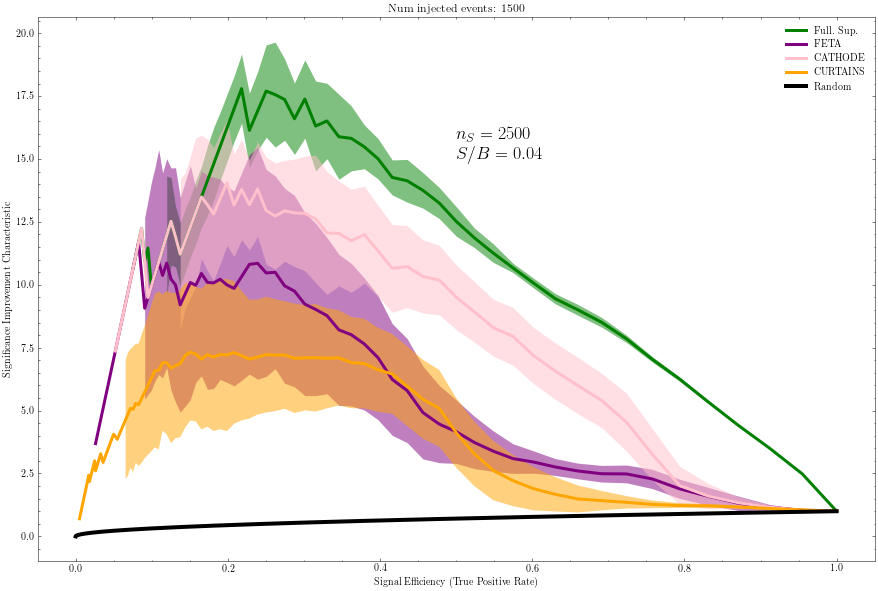

In [29]:

keys = ["full_sup", "feta", "cathode", "curtains"]

for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10))

    for k in keys:
        plt.plot(x_axis, mean_sics_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

        plt.fill_between(x_axis, mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 15, "$n_S = 2500$\n$S/B = 0.04$", fontsize = f)

    plt.legend()
    plt.xlabel("Signal Efficiency (True Positive Rate)")    
    plt.ylabel("Significance Improvement Characteristic")
    plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/sic{n}.png", dpi = dpi)
    
    plt.show()

# Rejection

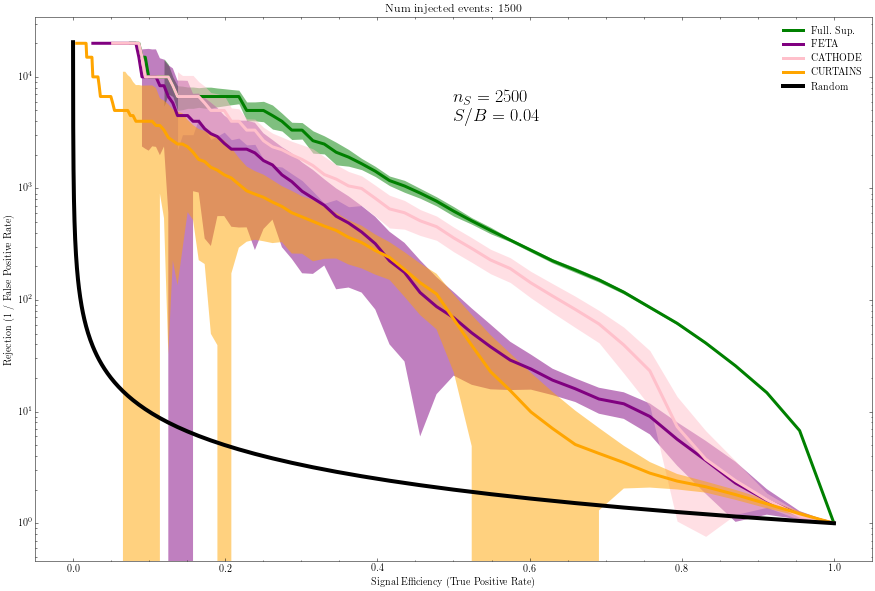

In [30]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        plt.plot(x_axis, mean_rejections_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

        plt.fill_between(x_axis, mean_rejections_dict[k][n][0] - mean_rejections_dict[k][n][1],
                         mean_rejections_dict[k][n][0] + mean_rejections_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)

    plt.plot(x_axis[184:], 1.0/x_axis[184:], label = "Random", color = "black", linewidth = l+1)
    
    plt.text(0.5, 4000, "$n_S = 2500$\n$S/B = 0.04$", fontsize = f)

    plt.legend()
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)")
    plt.ylabel("Rejection (1 / False Positive Rate)")
    plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/rej_{n}.png", dpi = dpi)

    plt.show()

## SIC vs rej

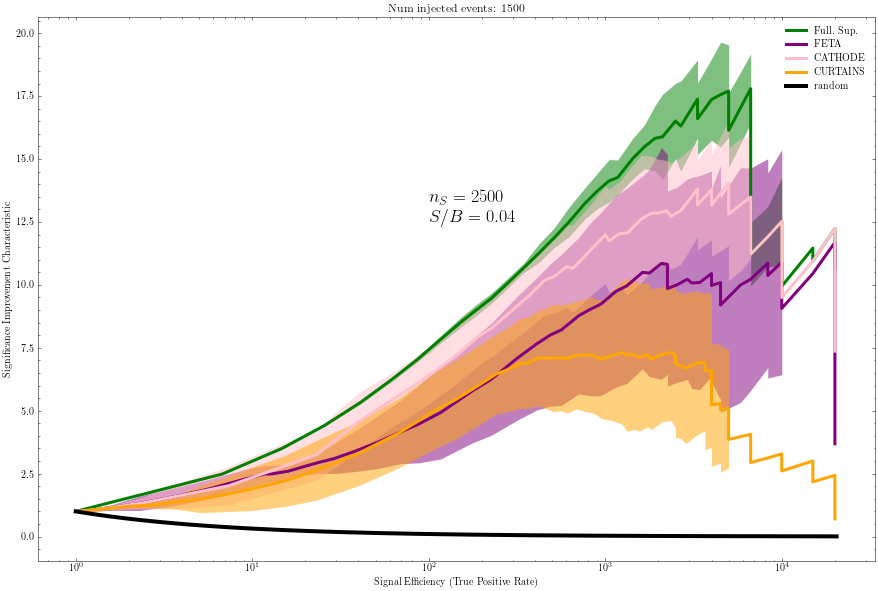

In [31]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        plt.plot(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

        plt.fill_between(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)

    plt.plot(1.0/x_axis[184:], x_axis[184:]/np.sqrt(x_axis[184:]), label = "random", color = "black", linewidth = l+1)
    
    plt.text(100, 12.5, "$n_S = 2500$\n$S/B = 0.04$", fontsize = f)

    plt.legend()
    plt.xscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)")
    plt.ylabel("Significance Improvement Characteristic")
    plt.title(f"Num injected events: {n}")
    
    fig.savefig(f"paper_plots/sic_vs_rej_{n}.png", dpi = dpi)


    plt.show()

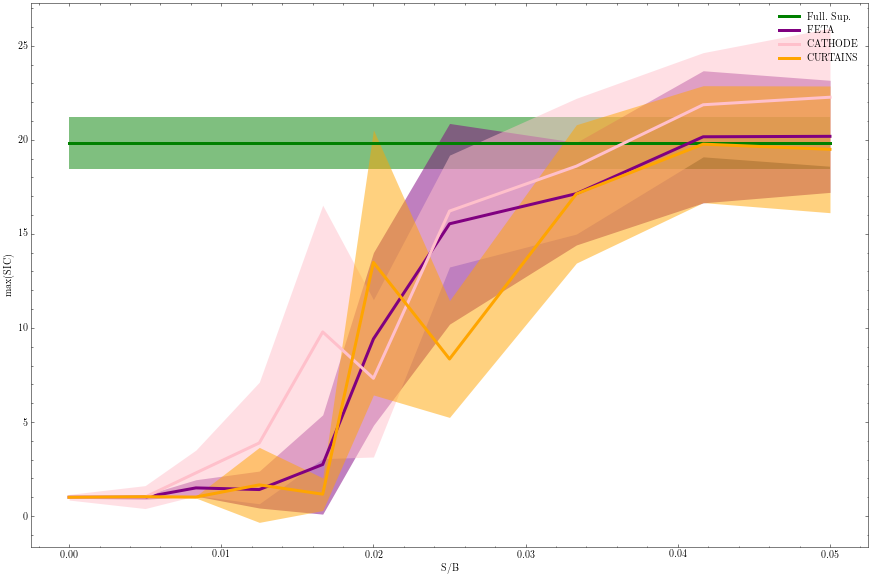

In [32]:
x_vals = [n / 60000 for n in n_sig_inj]



fig = plt.figure(figsize = (15, 10)) 
for k in keys:

    plt.plot(x_vals, mean_max_sics_dict[k][0], label = labels_dict[k], color = colors_dict[k], linewidth = l)

    plt.fill_between(x_vals, mean_max_sics_dict[k][0] -mean_max_sics_dict[k][1],
                        mean_max_sics_dict[k][0] + mean_max_sics_dict[k][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)
   

    #plt.plot(x_axis, 1.0/x_axis, label = "random", color = "black", linewidth = 3)

plt.legend()
plt.xlabel("S/B")
plt.ylabel("max(SIC)")

fig.savefig(f"paper_plots/maxsic.png", dpi = dpi)

plt.show()





# Combining background events